In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import math
sys.path.insert(0, 'code')

In [74]:
import json

import torch
import numpy as np
from easydict import EasyDict as edict
from PIL import Image
from filmant import load_filmant
from utils import IntermediateLayerGetter, load_vocab
from datasets import GQADataset, collate_fn_gqa, ClevrDataset, collate_fn
from visualize_attentions import plot_word_img_attn, idxs_to_question
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

In [5]:
cfg = {'COMET_PROJECT_NAME': 'filmant-clevr',
 'CUDA': True,
 'DATASET': {'COGENT': '',
             'DATASET': 'clevr',
             'DATA_DIR': '/storage1/datasets/CLEVR_v1.0/features',
             'IGNORE_TOKEN': ''},
 'EVAL': False,
 'GPU_ID': '0',
 'LOGDIR': 'filmant2_clevr',
 'SAMPLE': False,
 'TEST': False,
 'TEST_BATCH_SIZE': 256,
 'TRAIN': {'BATCH_SIZE': 64,
           'CLIP': 8,
           'CLIP_GRADS': True,
           'EALRY_STOPPING': True,
           'FLAG': True,
           'LEARNING_RATE': 5e-05,
           'MAX_EPOCHS': 40,
           'PATIENCE': 5,
           'RADAM': True,
           'SNAPSHOT_INTERVAL': 5,
           'VAR_DROPOUT': False,
           'WEIGHT_INIT': 'xavier_uniform'},
 'WORKERS': 1,
 'cfg_file': 'cfg/filmant2.yml',
 'exp_name': 'filmant2_clevr',
 'logcomet': True,
 'manualSeed': 6446,
 'model': {'PE_dropout': 0.1,
           'cnn_dim': 256,
           'd_model': 256,
           'in_channels': 1024,
           'n_filmblocks': 2,
           'n_instructions': 3,
           'n_operations': 1,
           'transformer_heads': 4,
           'transformer_nlayers': 4,},
 'resume_model': 'data/filmant2_clevr/Model/model_checkpoint_000015.pth',
 'resume_model_ema': None,
 'start_epoch': None}

cfg = edict(cfg)

dataset = cfg.DATASET.DATASET
cfg.DATASET.DATASET = dataset

if dataset == 'clevr':
    dataset_root = '/storage1/datasets/CLEVR_v1.0/'
#     data_dir = os.path.join(dataset_root, 'data')
    data_dir = os.path.join(dataset_root, 'features')
    images_dir = os.path.join(dataset_root, 'images')
elif dataset == 'gqa':
    dataset_root = '/storage1/datasets/GQA/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
cfg.DATASET.DATA_DIR = data_dir

In [6]:
split = 'val'
if cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif cfg.DATASET.DATASET == 'clevr':
    ds = ClevrDataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(dataset_root, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
    
vocab = load_vocab(cfg)
reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']
num_answers = len(reverse_answer_dic)


In [57]:
model = load_filmant(vocab, cfg)
state = torch.load('../../rmanterola/repos/FiLMac/data/filmant2_clevr/Model/model_checkpoint_000035.pth', map_location='cpu')
model.load_state_dict(state['model'])
model.eval()

return_layers = {
    'kb_attn_idty': 'kb_attn',
    'res_block_idty' : 'res_block_idty',
    'features_idty' : 'features_idty',
    'question_to_instruction.transformer.layers.3.self_attn' : 'cw_attn',
    'transformer.layers.0.self_attn' : 'transformer_attn_0',
    'transformer.layers.1.self_attn' : 'transformer_attn_1',
    'transformer.layers.2.self_attn' : 'transformer_attn_2',
    'transformer.layers.3.self_attn' : 'transformer_attn_3',
}
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

num_steps = cfg.model.n_instructions



In [10]:
for layer in ['0', '1', '2', '3']:
    print(f'Layer -- {layer}')
    for v, i in enumerate(mid_outputs[f'transformer_attn_{layer}'][1][0]):
        print(f'U_{v} ' + str(i))
    

Layer -- 0
U_0 tensor([0.0137, 0.2601, 0.2862, 0.4400], device='cuda:0')
U_1 tensor([0.0827, 0.3026, 0.3465, 0.2682], device='cuda:0')
U_2 tensor([0.0846, 0.3003, 0.3431, 0.2720], device='cuda:0')
U_3 tensor([0.0128, 0.2493, 0.2382, 0.4997], device='cuda:0')
Layer -- 1
U_0 tensor([0.0182, 0.1528, 0.1572, 0.6717], device='cuda:0')
U_1 tensor([0.3085, 0.2038, 0.2150, 0.2727], device='cuda:0')
U_2 tensor([0.3067, 0.2045, 0.2152, 0.2736], device='cuda:0')
U_3 tensor([0.0677, 0.4403, 0.4469, 0.0451], device='cuda:0')
Layer -- 2
U_0 tensor([0.0128, 0.2363, 0.2243, 0.5265], device='cuda:0')
U_1 tensor([0.0332, 0.1228, 0.1135, 0.7305], device='cuda:0')
U_2 tensor([0.0323, 0.1223, 0.1127, 0.7327], device='cuda:0')
U_3 tensor([0.1176, 0.3878, 0.4049, 0.0897], device='cuda:0')
Layer -- 3
U_0 tensor([0.0287, 0.3976, 0.4069, 0.1668], device='cuda:0')
U_1 tensor([0.0807, 0.3153, 0.3249, 0.2791], device='cuda:0')
U_2 tensor([0.0785, 0.3141, 0.3234, 0.2841], device='cuda:0')
U_3 tensor([0.0310, 0.4513

In [59]:
CLASSES = {
            'number':['0','1','2','3','4','5','6','7','8','9','10'],
            'material':['rubber','metal'],
            'color':['cyan','blue','yellow','purple','red','green','gray','brown'],
            'shape':['sphere','cube','cylinder'],
            'size':['large','small'],
            'exist':['yes','no']
}

In [60]:
def find_class(ans):
    token = vocab['answer_idx_to_token'][ans]
    for k,v in CLASSES.items():
        if token in v: return k
    return False

In [93]:
correct = {k : 0 for k in CLASSES.keys()}
predicted = {k : 0 for k in CLASSES.keys()}

In [62]:
loader = DataLoader(dataset=ds, batch_size=cfg.TEST_BATCH_SIZE, drop_last=False,
                                                shuffle=False, num_workers=cfg.WORKERS, collate_fn=collate_fn)

In [96]:
pbar = tqdm(loader, total=len(loader), desc='Val')
for dato in pbar:
    with torch.no_grad():
        scores = model(dato['question'].cuda(), dato['question_length'], dato['image'].cuda())
        pred = scores.detach().argmax(1)
        corr = (dato['answer'] == pred.cpu())
        for p in range(len(corr)):
            if corr[p]:
                predicted[find_class(pred[p].item())] += 1
            correct[find_class(dato['answer'][p].item())] += 1

In [102]:
for k,v in predicted.items():
    ret = round(v / correct[k], 2)
    print(f'{k} : {ret}')

number : 0.66
material : 0.82
color : 0.66
shape : 0.73
size : 0.8
exist : 0.77


In [27]:
pred.item()

2

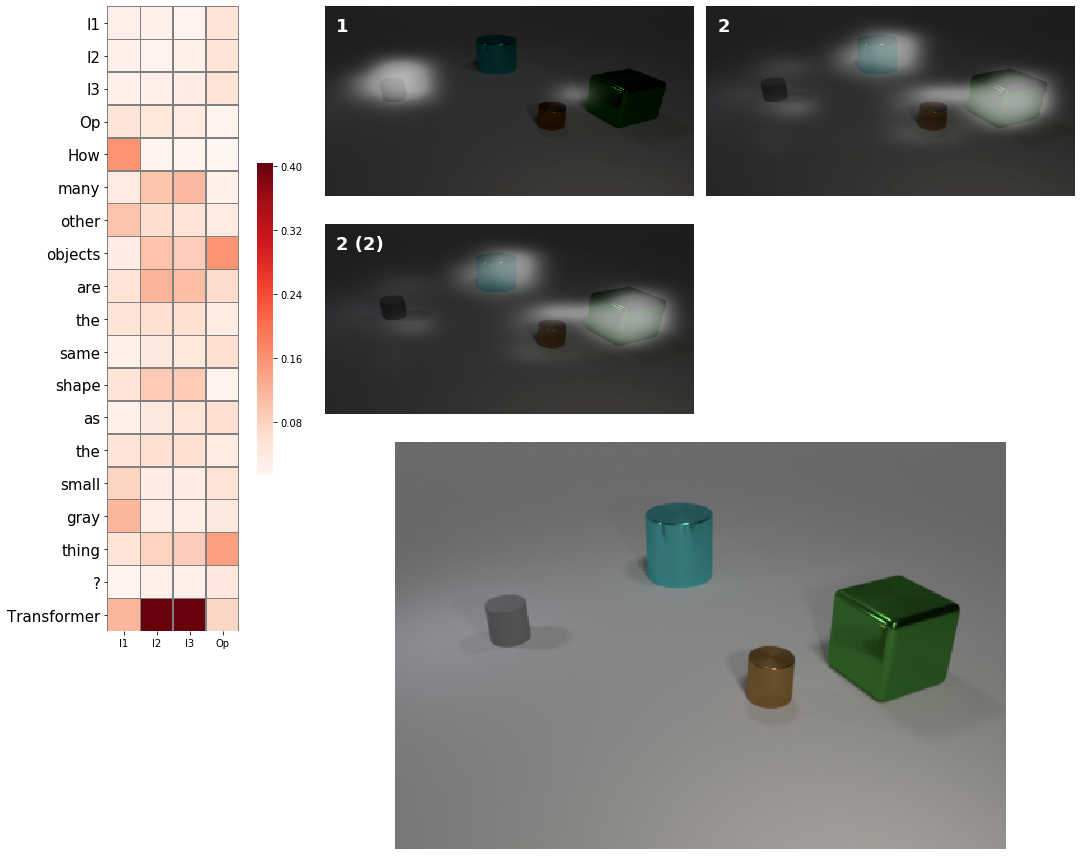

In [58]:
q_index = 897

if dataset == 'gqa':
    b = collate_fn_gqa([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])
    
with torch.no_grad():
    mid_outputs, output = mid_getter(b['question'].cuda(), b['question_length'], b['image'].cuda())

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

plot_word_img_attn(
    mid_outputs,
    num_steps,
    tokenized_questions,
    images_dir,
    image_filename,
    pred,
    gt,
    vis='attn'
)

In [194]:
import matplotlib.pyplot as plt

In [195]:
mid_outputs['features_idty'].shape

torch.Size([1, 1024, 14, 14])

0.39832788584183676


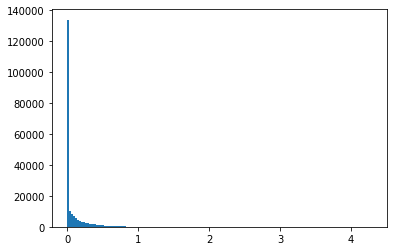

In [196]:
data = mid_outputs['features_idty'].cpu().numpy().flatten()
print((data != 0).sum() / len(data))
plt.hist(data.flatten(), bins=150);

In [197]:
# data = mid_outputs['stem_idty'].cpu().numpy().flatten()
# print((data > -0.9).sum() / len(data))
# plt.hist(data.flatten(), bins=150);

0.38839285714285715


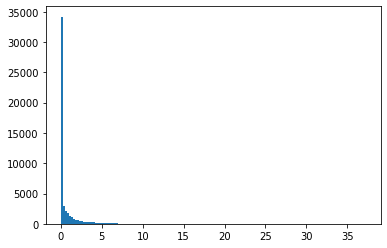

In [198]:
data = mid_outputs['res_block_idty'][0].cpu().numpy().flatten()
print((data != 0).sum() / len(data))
plt.hist(data.flatten(), bins=150);

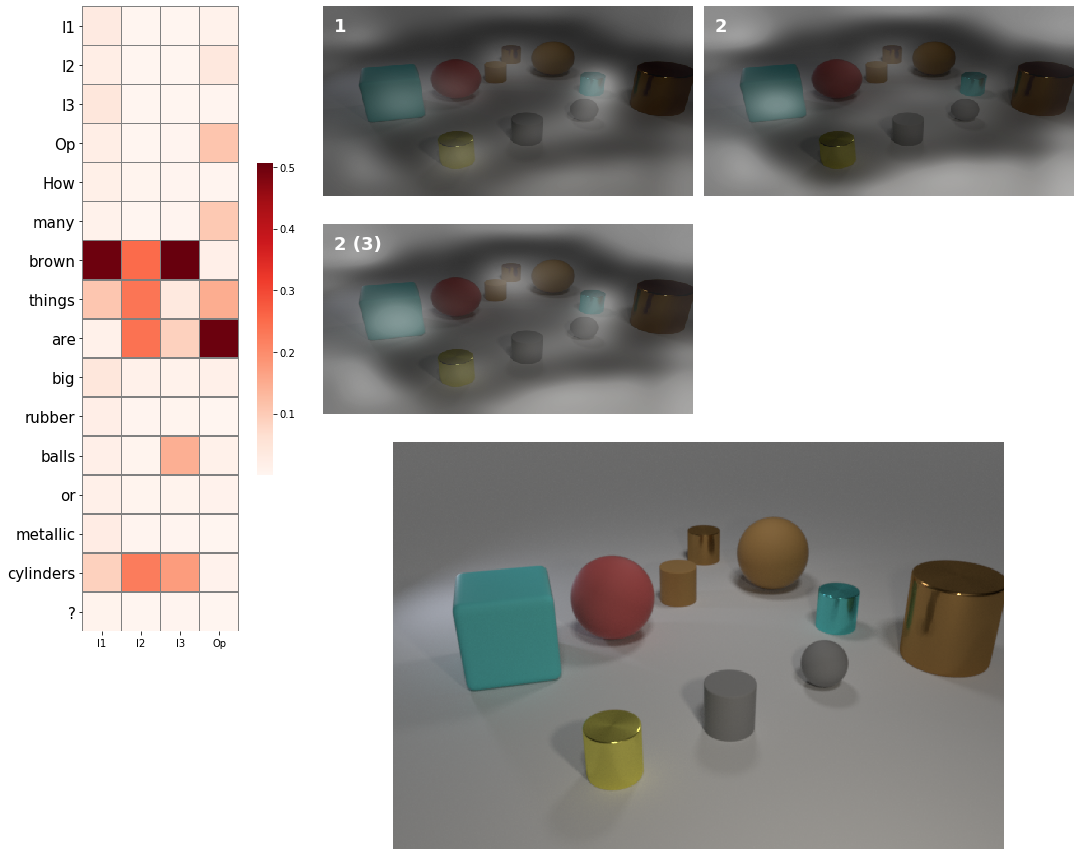

In [199]:
plot_word_img_attn(
    mid_outputs,
    num_steps,
    tokenized_questions,
    images_dir,
    image_filename,
    pred,
    gt,
    vis='know'
)